**INTEGRANTES DEL EQUIPO**
- GUSTAVO ALONSO ANAYA MORENO
- ARON URIEL GUZMAN CARDOSO
- PERLA PAOLA PANTALEON BEDOLLA


# Proyecto de búsqueda en laberinto con la librería baile

---
## 1. Definición  del problema

- **Estado**: Una tupla `(fila, columna)` que indica la posición actual en el laberinto.  
- **Operador sucesor**: Desde un estado, se puede mover en 4 direcciones (arriba, abajo, izquierda, derecha), siempre que la celda no sea pared.  
- **Estado meta**: Una celda de salida definida previamente.  
- **Heurística**: Distancia de Manhattan entre el estado actual y la meta.  


In [ ]:

from SimpleSearch import node, BlindSearch
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

## 2. Definición del Laberinto

In [ ]:
maze = [
    [0,0,1,0,0,0,1,0,0,0],
    [1,0,1,0,1,0,1,0,1,0],
    [0,0,0,0,1,0,0,0,1,0],
    [0,1,1,1,1,1,1,0,1,0],
    [0,0,0,0,0,0,1,0,1,0],
    [1,1,1,1,1,0,1,0,1,0],
    [0,0,0,0,1,0,0,0,1,0],
    [0,1,1,0,1,0,1,1,1,0],
    [0,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0]
]

start_state = (0,0)   
goal_state  = (9,9)   


## 3. Funciones del problema (sucesor, meta, heurística)

In [ ]:

def successor(n):
    moves = [(-1,0,"UP"), (1,0,"DOWN"), (0,-1,"LEFT"), (0,1,"RIGHT")]
    successors = []
    x, y = n.state
    for dx, dy, action in moves:
        nx, ny = x+dx, y+dy
        if 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0:
            new_n = node(state=(nx,ny), parent=n, depth=n.depth+1, op=action)
            successors.append(new_n)
    return successors

def goal(n, goal_state):
    return n.state == goal_state

def heuristic(n, goal_state):
    (x1,y1) = n.state
    (x2,y2) = goal_state
    return abs(x1-x2) + abs(y1-y2)


## 4. Ejecución de búsquedas

In [ ]:

start_node = node(state=start_state)

#ALGORITOMO 

search_bfs = BlindSearch(start=start_node, successor=successor, goal=goal, strategy="bfs", goal_state=goal_state)
result_bfs = search_bfs.find()
print("Camino BFS:", result_bfs.getPath())

#ALGORITMO DFS
search_dfs = BlindSearch(start=start_node, successor=successor, goal=goal, strategy="dfs", goal_state=goal_state)
result_dfs = search_dfs.find()
print("Camino DFS:", result_dfs.getPath())

#ALGORITMO A*
search_astar = BlindSearch(start=start_node, successor=successor, goal=goal,
                           strategy="a*", goal_state=goal_state, heuristic=heuristic)
result_astar = search_astar.find()
print("Camino A*:", result_astar.getPath())


finished in 2 iterations
Se acabaron los estados: 0
Camino BFS: [('Solution not found', '', 0)]
finished in 26 iterations
Se acabaron los estados: 6
Camino DFS: [((0, 0), '', 0), ((0, 1), 'RIGHT', 1), ((1, 1), 'DOWN', 2), ((2, 1), 'DOWN', 3), ((2, 2), 'RIGHT', 4), ((2, 3), 'RIGHT', 5), ((1, 3), 'UP', 6), ((0, 3), 'UP', 7), ((0, 4), 'RIGHT', 8), ((0, 5), 'RIGHT', 9), ((1, 5), 'DOWN', 10), ((2, 5), 'DOWN', 11), ((2, 6), 'RIGHT', 12), ((2, 7), 'RIGHT', 13), ((3, 7), 'DOWN', 14), ((4, 7), 'DOWN', 15), ((5, 7), 'DOWN', 16), ((6, 7), 'DOWN', 17), ((6, 6), 'LEFT', 18), ((6, 5), 'LEFT', 19), ((7, 5), 'DOWN', 20), ((8, 5), 'DOWN', 21), ((8, 6), 'RIGHT', 22), ((8, 7), 'RIGHT', 23), ((8, 8), 'RIGHT', 24), ((8, 9), 'RIGHT', 25), ((9, 9), 'DOWN', 26)]
finished in 2 iterations
Se acabaron los estados: 0
Camino A*: [('Solution not found', '', 0)]


**Dudas sobre, porque los metodos BFS y A(*) no estasn encontrando una solucion**

## 5.  Para la visualización de caminos

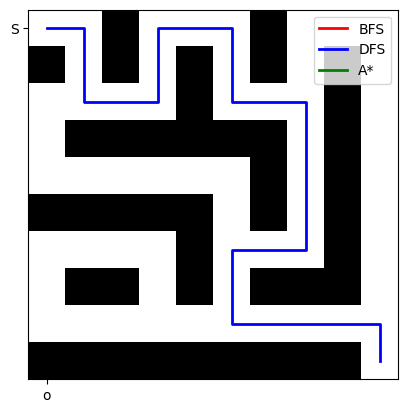

In [ ]:
def show_multiple_paths(maze, paths_dict):
    """
    paths_dict: diccionario con { "BFS": path_bfs, "DFS": path_dfs, "A*": path_astar }
    """
    grid = np.array(maze)
    plt.imshow(grid, cmap="binary")

    colors = {"BFS": "red", "DFS": "blue", "A*": "green"}
    
    for name, path in paths_dict.items():
        if path:
            xs = [p[0][1] for p in path]
            ys = [p[0][0] for p in path]
            plt.plot(xs, ys, color=colors[name], linewidth=2, label=name)

    plt.legend()
    plt.show()


# PARA MOSTRAR LOS TRES CAMINOS
paths_dict = {
    "BFS": result_bfs.getPath(),
    "DFS": result_dfs.getPath(),
    "A*": result_astar.getPath()
}

show_multiple_paths(maze, paths_dict)


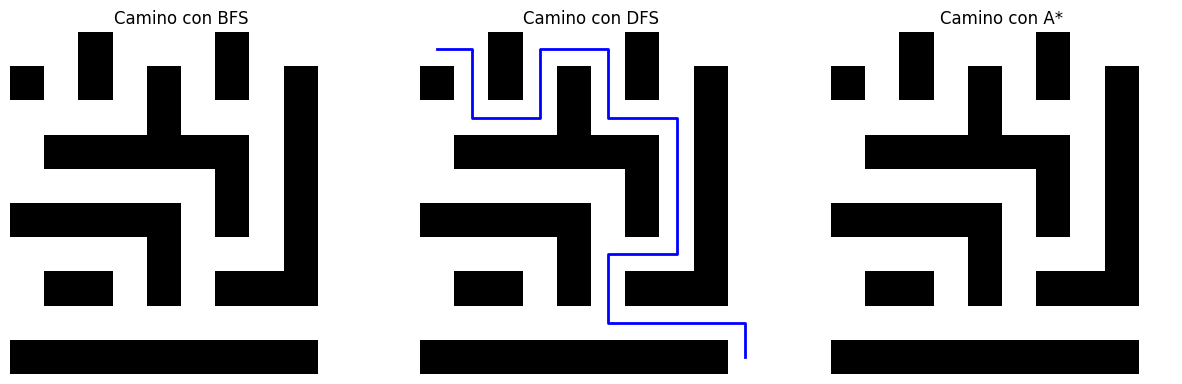

In [ ]:
def show_paths_separately(maze, paths_dict):
    grid = np.array(maze)
    fig, axes = plt.subplots(1, len(paths_dict), figsize=(15,5))

    colors = {"BFS": "red", "DFS": "blue", "A*": "green"}
    
    for ax, (name, path) in zip(axes, paths_dict.items()):
        ax.imshow(grid, cmap="binary")
        if path:
            xs = [p[0][1] for p in path]
            ys = [p[0][0] for p in path]
            ax.plot(xs, ys, color=colors[name], linewidth=2)
        ax.set_title(f"Camino con {name}")
        ax.axis("off")
    
    plt.show()



paths_dict = {
    "BFS": result_bfs.getPath(),
    "DFS": result_dfs.getPath(),
    "A*": result_astar.getPath()
}

show_paths_separately(maze, paths_dict)


In [ ]:


def run_search(strategy, heuristic=None):
    start_node = node(state=start_state)
    search = BlindSearch(start=start_node, successor=successor, goal=goal,
                         strategy=strategy, goal_state=goal_state, heuristic=heuristic)
    t0 = time.time()
    result = search.find()
    t1 = time.time()
    elapsed = t1 - t0
    path = result.getPath()
    return {
        "Estrategia": strategy,
        "Tiempo (s)": round(elapsed, 6),
        "Nodos expandidos": len(search.visited),
        "Longitud del camino": len(path)
    }

results = []
results.append(run_search("bfs"))
results.append(run_search("dfs"))
results.append(run_search("a*", heuristic=heuristic))

df_results = pd.DataFrame(results)
df_results


finished in 2 iterations
Se acabaron los estados: 0
finished in 26 iterations
Se acabaron los estados: 6
finished in 2 iterations
Se acabaron los estados: 0


,Estrategia,Tiempo (s),Nodos expandidos,Longitud del camino
0,bfs,0.000161,2,1
1,dfs,0.000189,32,27
2,a*,0.000068,2,1
